In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Convert mustang dataset to SWF

## Parsing the raw data

In [3]:
atlas_raw = pd.read_csv("../data/mustang_release_v1.0beta.csv", nrows=50000)
atlas_raw = atlas_raw.dropna(subset=['submit_time', 'start_time', 'end_time'])
atlas_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47612 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_ID          47612 non-null  int64 
 1   group_ID         47612 non-null  int64 
 2   submit_time      47612 non-null  object
 3   start_time       47612 non-null  object
 4   end_time         47612 non-null  object
 5   wallclock_limit  47612 non-null  object
 6   job_status       47612 non-null  object
 7   node_count       47612 non-null  int64 
 8   tasks_requested  47612 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.6+ MB


In [4]:
max_wallclock_limit = 57600 # 16 hours

atlas_raw['submit_time'] = pd.to_datetime(atlas_raw['submit_time'], utc=True, format='%Y-%m-%d %H:%M:%S%z')
atlas_raw['start_time'] = pd.to_datetime(atlas_raw['start_time'], utc=True, format='%Y-%m-%d %H:%M:%S%z')
atlas_raw['end_time'] = pd.to_datetime(atlas_raw['end_time'], utc=True, format='%Y-%m-%d %H:%M:%S%z')
atlas_raw['wallclock_limit'] = pd.to_timedelta(atlas_raw['wallclock_limit'])
atlas_raw['job_status'] = atlas_raw['job_status'].astype('category')

atlas_raw = atlas_raw[(atlas_raw['job_status'] == "COMPLETED") & (atlas_raw['wallclock_limit'].dt.total_seconds().astype('int64') <= max_wallclock_limit)]

atlas_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32197 entries, 7 to 49999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   user_ID          32197 non-null  int64              
 1   group_ID         32197 non-null  int64              
 2   submit_time      32197 non-null  datetime64[ns, UTC]
 3   start_time       32197 non-null  datetime64[ns, UTC]
 4   end_time         32197 non-null  datetime64[ns, UTC]
 5   wallclock_limit  32197 non-null  timedelta64[ns]    
 6   job_status       32197 non-null  category           
 7   node_count       32197 non-null  int64              
 8   tasks_requested  32197 non-null  int64              
dtypes: category(1), datetime64[ns, UTC](3), int64(4), timedelta64[ns](1)
memory usage: 2.2 MB


## Build the SWF data

In [5]:
swf_fields = [
    "Job number", 
    "Submit time", 
    "Wait time", 
    "Run time", 
    "Number of allocated processors", 
    "Average CPU time used", 
    "Used memory", 
    "Requested number of processors", 
    "Requested time", 
    "Requested memory", 
    "Status", 
    "User ID", 
    "Group ID", 
    "Executable (application) number", 
    "Queue number", 
    "Partition number", 
    "Preceding job number", 
    "Think time from preceding job"
]
atlas_swf = pd.DataFrame(columns=swf_fields)
atlas_swf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Job number                       0 non-null      object
 1   Submit time                      0 non-null      object
 2   Wait time                        0 non-null      object
 3   Run time                         0 non-null      object
 4   Number of allocated processors   0 non-null      object
 5   Average CPU time used            0 non-null      object
 6   Used memory                      0 non-null      object
 7   Requested number of processors   0 non-null      object
 8   Requested time                   0 non-null      object
 9   Requested memory                 0 non-null      object
 10  Status                           0 non-null      object
 11  User ID                          0 non-null      object
 12  Group ID                         0 non-null      obje

### Processing the chunk

In [6]:
number_of_cores_per_node = 24

atlas_swf['Submit time'] = atlas_raw['submit_time']
atlas_swf['Wait time'] = atlas_raw['start_time'] - atlas_raw['submit_time']
atlas_swf['Run time'] = atlas_raw['end_time'] - atlas_raw['start_time']
atlas_swf['Number of allocated processors'] = atlas_raw['node_count'] * number_of_cores_per_node
atlas_swf['Requested number of processors'] = atlas_raw['tasks_requested']
atlas_swf['Requested time'] = atlas_raw['wallclock_limit']
atlas_swf['User ID'] = atlas_raw['user_ID']
atlas_swf['Group ID'] = atlas_raw['group_ID']

atlas_swf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32197 entries, 7 to 49999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   Job number                       0 non-null      object             
 1   Submit time                      32197 non-null  datetime64[ns, UTC]
 2   Wait time                        32197 non-null  timedelta64[ns]    
 3   Run time                         32197 non-null  timedelta64[ns]    
 4   Number of allocated processors   32197 non-null  int64              
 5   Average CPU time used            0 non-null      object             
 6   Used memory                      0 non-null      object             
 7   Requested number of processors   32197 non-null  int64              
 8   Requested time                   32197 non-null  timedelta64[ns]    
 9   Requested memory                 0 non-null      object             
 10

In [7]:
atlas_swf.head()

,Job number,Submit time,Wait time,Run time,Number of allocated processors,Average CPU time used,Used memory,Requested number of processors,Requested time,Requested memory,Status,User ID,Group ID,Executable (application) number,Queue number,Partition number,Preceding job number,Think time from preceding job
7,NaN,2011-10-27 21:38:14+00:00,0 days 00:00:03,0 days 00:00:03,48,NaN,NaN,48,0 days 02:00:00,NaN,NaN,354,357,NaN,NaN,NaN,NaN,NaN
11,NaN,2011-10-27 22:09:44+00:00,0 days 00:00:04,0 days 00:00:04,48,NaN,NaN,48,0 days 02:00:00,NaN,NaN,354,357,NaN,NaN,NaN,NaN,NaN
17,NaN,2011-10-27 23:00:29+00:00,0 days 00:00:28,0 days 00:00:03,48,NaN,NaN,48,0 days 02:00:00,NaN,NaN,354,357,NaN,NaN,NaN,NaN,NaN
18,NaN,2011-10-27 23:04:07+00:00,0 days 00:00:27,0 days 00:05:48,48,NaN,NaN,48,0 days 02:00:00,NaN,NaN,354,357,NaN,NaN,NaN,NaN,NaN
19,NaN,2011-10-27 23:17:22+00:00,0 days 00:00:07,0 days 00:03:48,48,NaN,NaN,48,0 days 02:00:00,NaN,NaN,354,357,NaN,NaN,NaN,NaN,NaN


### Formating the data

In [8]:
irrelevant_fields = [
    "Average CPU time used",
    "Used memory",
    "Requested memory",
    "Status",
    "Executable (application) number",
    "Queue number",
    "Partition number",
    "Preceding job number",
    "Think time from preceding job"
]

# Sort the dataframe by `Submit time` in ascending order
atlas_swf = atlas_swf.sort_values(by='Submit time', ascending=True)

# Subtract the first `Submit time` from all `Submit time`s
atlas_swf['Submit time'] = atlas_swf['Submit time'] - atlas_swf['Submit time'].iloc[0]

# Convert `Submit time` to seconds
atlas_swf['Submit time'] = atlas_swf['Submit time'].dt.total_seconds().astype('int64')

# Convert `Wait time`, `Run time` and `Requested time` to seconds
atlas_swf['Wait time'] = atlas_swf['Wait time'].dt.total_seconds().astype('int64')
atlas_swf['Run time'] = atlas_swf['Run time'].dt.total_seconds().astype('int64')
atlas_swf['Requested time'] = atlas_swf['Requested time'].dt.total_seconds().astype('int64')

# Reset the index and assign the index + 1 as the `Job number`
atlas_swf = atlas_swf.reset_index(drop=True)
atlas_swf['Job number'] = atlas_swf.index + 1

atlas_swf[irrelevant_fields] = -1

atlas_swf.head()

,Job number,Submit time,Wait time,Run time,Number of allocated processors,Average CPU time used,Used memory,Requested number of processors,Requested time,Requested memory,Status,User ID,Group ID,Executable (application) number,Queue number,Partition number,Preceding job number,Think time from preceding job
0,1,0,3,3,48,-1,-1,48,7200,-1,-1,354,357,-1,-1,-1,-1,-1
1,2,1890,4,4,48,-1,-1,48,7200,-1,-1,354,357,-1,-1,-1,-1,-1
2,3,4935,28,3,48,-1,-1,48,7200,-1,-1,354,357,-1,-1,-1,-1,-1
3,4,5153,27,348,48,-1,-1,48,7200,-1,-1,354,357,-1,-1,-1,-1,-1
4,5,5948,7,228,48,-1,-1,48,7200,-1,-1,354,357,-1,-1,-1,-1,-1


# Analyzing the data

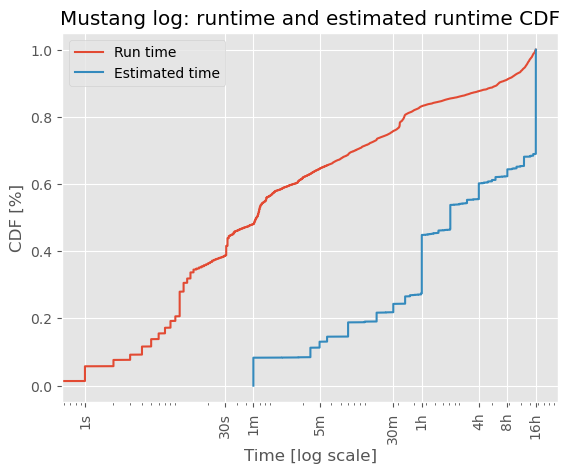

In [12]:
plt.style.use('ggplot')

# Get the run times
run_times = atlas_swf["Run time"]
estimated_run_times = atlas_swf["Requested time"]

# Calculate the cumulative distribution function
run_times_sorted = np.sort(run_times)
cdf = np.linspace(0, 1, len(run_times_sorted))

estimated_run_times_sorted = np.sort(estimated_run_times)
estimated_cdf = np.linspace(0, 1, len(estimated_run_times_sorted))

# Plot the cumulative distribution function
plt.plot(run_times_sorted, cdf)
plt.plot(estimated_run_times_sorted, estimated_cdf)
plt.xlabel("Time [log scale]")
plt.ylabel("CDF [%]")
plt.title("Mustang log: runtime and estimated runtime CDF")
plt.xscale("log")
plt.legend(["Run time", "Estimated time"])

# Set the x-axis tick locations
tick_locations = [1, 30, 60, 300, 1800, 3600, 14400, 28800, 57600]
tick_labels = ["1s", "30s", "1m", "5m", "30m", "1h", "4h", "8h", "16h"]
plt.xticks(tick_locations, tick_labels, rotation=90, ha='center', va='top')
# plt.gca().set_xlim((0, 57600))
# plt.gca().set_ylim((0, 1))
# plt.yticks(np.arange(0, 1.1, 0.05))
plt.show()